<a href="https://colab.research.google.com/github/theeranat/dads5001_midterm/blob/main/mid_term.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fuzzywuzzy
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
!pip install Levenshtein

--2022-04-02 12:06:37--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2022-04-02 12:06:38--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf.7’

thsarabunnew-webfon 100%[===================>]  96.00K  --.-KB/s    in 0.009s  

2022-04-02 12:06:38 (10.1 MB/s) - 

In [2]:
import os
import datetime as dt
from datetime import datetime, timedelta
import fuzzywuzzy
from fuzzywuzzy import process
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib as mpl
import  matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes ,inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import scipy.signal
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

from google.colab import drive
drive.mount('/gdrive')

pd.options.mode.chained_assignment = None 
plt.style.use('fivethirtyeight')
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.color'] = "#bfbfbf"
plt.rcParams['lines.linestyle'] = 'solid'
plt.rcParams['grid.linestyle'] = '--'
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New',size=10)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
class data_ingestion:
    
    def concate_file(self,dir:str,file:list,cols:list):
        self.dir = dir
        self.file=file
        self.cols=cols
        temp_df=pd.DataFrame(columns=self.cols)

        for file_name in self.file:
            try:
                path_file=os.path.join(dir,file_name)    
                df=pd.read_parquet(path_file)
                df['filename']=file_name
                for i in self.cols:
                    df[i]=df[i].astype(str)
                temp_df=pd.concat([temp_df,df])
                print('Finish concat',file_name)

            except Exception as e:
                print(f'{file_name} error' )
                raise e
        tran_data=data_tranform()
        temp_df=tran_data.convert_date(temp_df,['announce_date','Notified date'],'%d/%m/%Y')
        temp_df.drop(temp_df.loc[(temp_df.announce_date=='2021-08-12')&\
            (temp_df.filename=='confirmed-cases-since-120163.parquet')].index,axis=0,inplace=True) #ลบออกเนื่องจากข้อมูลซ้ำกับไฟล์อื่น
        temp_df.drop(['filename'],axis=1,inplace=True)
        print('Successful concatinate file your file ')
        return temp_df




In [4]:
class data_tranform():
    
    def covert_float(self,df,col):
        self.df=df.copy()   #ไม่ให้อ้างอิงไม่ที่ memory location เดียวกัน
        self.col=col
        for i in enumerate(self.df[self.col]):
            try:
                float(i[1])
            except Exception as e:
                idx=self.df.loc[self.df[self.col]==i[1]].index
                self.df.loc[idx,self.col]=np.nan
                print(f'index {idx[0]} value {i[1]} has been replace with nan')

        return self.df[self.col].astype(float)

    def convert_date(self,df,cols,format):
        self.df=df
        self.cols=cols
        self.format=format
        for i in self.cols:
            try:
                self.df[i] =df[i].replace('None',np.nan)
                self.df[i]=pd.to_datetime(self.df[i],format=self.format)
                print(f'Finish covert col {i} to dateTime')
            except Exception as e:
                print('Cannot convert to dateTime format because invalid format.')
                raise e
        return self.df

In [5]:
file_names = ['confirmed-cases-since-120163.parquet',
            'confirmed-cases-since-120864.parquet',            
            'confirmed-cases-since-271064.parquet',
            'confirmed-cases-since-280265.parquet']       
# 120163 :	12 January  2020	to   12 August   2021
# 120864 : 	12 August   2021	to   25 October  2021
# 271064 :	26 October  2021	to   27 February 2022
# 280265 :	28 February 2022    to	 20 March    2022

col=['No.', 'announce_date', 'Notified date', 'sex', 'age', 'Unit','nationality', 
    'province_of_isolation', 'risk', 'province_of_onset','district_of_onset','filename']
df = data_ingestion().concate_file('/gdrive/My Drive/DADS5001/Data/',file_names,col)

Finish concat confirmed-cases-since-120163.parquet
Finish concat confirmed-cases-since-120864.parquet
Finish concat confirmed-cases-since-271064.parquet
Finish concat confirmed-cases-since-280265.parquet
Finish covert col announce_date to dateTime
Finish covert col Notified date to dateTime
Successful concatinate file your file 


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3308405 entries, 0 to 484352
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   No.                    object        
 1   announce_date          datetime64[ns]
 2   Notified date          datetime64[ns]
 3   sex                    object        
 4   age                    object        
 5   Unit                   object        
 6   nationality            object        
 7   province_of_isolation  object        
 8   risk                   object        
 9   province_of_onset      object        
 10  district_of_onset      object        
 11  Unnamed: 11            float64       
dtypes: datetime64[ns](2), float64(1), object(9)
memory usage: 328.1+ MB


In [7]:
df.columns=df.columns.str.strip()
df.columns=df.columns.str.replace(' ','_')
df.columns=df.columns.str.replace('.','')
df.drop(columns=[i for i in list(df.columns) if 'Unnamed' in i],inplace=True)
df.replace(to_replace='None',value=np.nan,regex=False,inplace=True)
df.replace(to_replace='nan',value=np.nan,regex=False,inplace=True)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


,No,announce_date,Notified_date,sex,age,Unit,nationality,province_of_isolation,risk,province_of_onset,district_of_onset
0,1,2020-01-12,NaT,หญิง,61,ปี,China,กรุงเทพมหานคร,คนต่างชาติเดินทางมาจากต่างประเทศ,กรุงเทพมหานคร,NaN
1,2,2020-01-17,NaT,หญิง,74,ปี,China,กรุงเทพมหานคร,คนต่างชาติเดินทางมาจากต่างประเทศ,กรุงเทพมหานคร,NaN
2,3,2020-01-22,NaT,หญิง,73,ปี,Thailand,นครปฐม,คนต่างชาติเดินทางมาจากต่างประเทศ,นครปฐม,เมือง
3,4,2020-01-22,NaT,ชาย,68,ปี,China,กรุงเทพมหานคร,คนต่างชาติเดินทางมาจากต่างประเทศ,กรุงเทพมหานคร,NaN
4,5,2020-01-24,NaT,หญิง,66,ปี,China,นนทบุรี,คนต่างชาติเดินทางมาจากต่างประเทศ,กรุงเทพมหานคร,NaN


In [8]:
df['age']=data_tranform().covert_float(df,'age')
df.drop(df.age.loc[df['age']>150].index,axis=0,inplace=True)
df.reset_index(inplace=True,drop=True)
df.head()

index 100164 value 55/664 has been replace with nan
index 738496 value 35/11 has been replace with nan


,No,announce_date,Notified_date,sex,age,Unit,nationality,province_of_isolation,risk,province_of_onset,district_of_onset
0,1,2020-01-12,NaT,หญิง,61.0,ปี,China,กรุงเทพมหานคร,คนต่างชาติเดินทางมาจากต่างประเทศ,กรุงเทพมหานคร,NaN
1,2,2020-01-17,NaT,หญิง,74.0,ปี,China,กรุงเทพมหานคร,คนต่างชาติเดินทางมาจากต่างประเทศ,กรุงเทพมหานคร,NaN
2,3,2020-01-22,NaT,หญิง,73.0,ปี,Thailand,นครปฐม,คนต่างชาติเดินทางมาจากต่างประเทศ,นครปฐม,เมือง
3,4,2020-01-22,NaT,ชาย,68.0,ปี,China,กรุงเทพมหานคร,คนต่างชาติเดินทางมาจากต่างประเทศ,กรุงเทพมหานคร,NaN
4,5,2020-01-24,NaT,หญิง,66.0,ปี,China,นนทบุรี,คนต่างชาติเดินทางมาจากต่างประเทศ,กรุงเทพมหานคร,NaN


In [9]:
sex_dict={}
for i in df.sex.unique():  
    if(('ห' in str(i)) or ('ญ' in str(i))):    #replace เพศ
        sex_dict[i]='หญิง'
    elif 'ช' in str(i):
        sex_dict[i]='ชาย'
    else :
        sex_dict[i]='ไม่ระบุ'
df['sex']=df['sex'].map(sex_dict)

In [10]:
df['Unit']=df.Unit.str.strip()

In [11]:
idx=df.loc[(df.age<1)&(pd.isna(df.Unit)==True)].index   #มี Age แต่ไม่มี unit ให้set เป้น nan
df.loc[idx,'age']=np.nan
idx=df.loc[df['Unit']=='วัน'].index
df.loc[idx,'new_age'] = 1

In [12]:
df['new_age'] = df['age'].copy()   #เปลี่ยนเดือนให้เป็นปี โดยถ้าเดือนน้อยกว่า 12 จะนับเป็น 1 ปี ทันที
age = 0
for i in range(0,36,12):
    if i ==0 :
        age+=1
        idx=df.loc[((df['age']>i) & (df['age']<=i+12))&(df['Unit']=='เดือน')].index
        df.loc[idx,'new_age'] = age
        
    else:
        age+=1
        idx=df.loc[((df['age']>i) & (df['age']<=i+12))&(df['Unit']=='เดือน')].index
        df.loc[idx,'new_age'] = age


In [13]:
print('date diff mean',np.mean(df['announce_date']-df['Notified_date']))
print('date diff std',np.std(df['announce_date']-df['Notified_date']))

date diff mean 1 days 00:00:29.352460528
date diff std 0 days 01:13:00.385256017


In [14]:
df['new_Notified_date']=df['announce_date'] - timedelta(days=1)

In [15]:
pro_of_iso=df[['province_of_isolation']]
pro_of_iso.fillna('ไม่ระบุ',axis=1,inplace=True)
pro_of_iso['province_of_isolation']=pro_of_iso.province_of_isolation.str.strip()
pro_of_iso.head()

,province_of_isolation
0,กรุงเทพมหานคร
1,กรุงเทพมหานคร
2,นครปฐม
3,กรุงเทพมหานคร
4,นนทบุรี


In [16]:
provience=pd.read_parquet(r'/gdrive/My Drive/DADS5001/Data/tranform_provience.parquet.gzip') #อ่านไฟล์จังหวัดในไทย
provience.head()

,CC-DESC,MALE,FEMALE,TOTAL,ADM1_TH,ADM1_EN,geometry
0,กรุงเทพมหานคร,2625938,2962284,5588222,กรุงเทพมหานคร,Bangkok,"POLYGON ((100.8553739771273 13.6919811065428, ..."
1,สมุทรปราการ,644516,706963,1351479,สมุทรปราการ,Samut Prakan,"POLYGON ((100.8553739771273 13.6919811065428, ..."
2,นนทบุรี,594308,682437,1276745,นนทบุรี,Nonthaburi,"POLYGON ((100.350288526894 14.1137124702543, 1..."
3,ปทุมธานี,557752,618660,1176412,ปทุมธานี,Pathum Thani,"POLYGON ((100.9124247580961 14.21391307193076,..."
4,พระนครศรีอยุธยา,393551,425537,819088,พระนครศรีอยุธยา,Phra Nakhon Si Ayutthaya,"POLYGON ((100.5940462592274 14.65592743570259,..."


In [17]:
pro_of_iso_check=pro_of_iso.merge(provience,how='left',\
            left_on='province_of_isolation',right_on='ADM1_TH') #ตรวจสอบว่าprovince_of_isolation ในraw data มีใน ADM1_TH หรือไม่
pro_of_iso_check.loc[pd.isnull(pro_of_iso_check['ADM1_TH'])==True]['province_of_isolation'].unique()

array(['ไม่ระบุ', 'กทม', 'ภููเก็ต'], dtype=object)

In [18]:
idx=pro_of_iso.loc[pro_of_iso['province_of_isolation']=='กทม'].index
pro_of_iso.loc[idx,'province_of_isolation']='กรุงเทพมหานคร'
idx=pro_of_iso.loc[pro_of_iso['province_of_isolation']=='ภููเก็ต'].index
pro_of_iso.loc[idx,'province_of_isolation']='ภูเก็ต'
df['province_of_isolation']=pro_of_iso['province_of_isolation']

In [19]:
df['nationality']=df['nationality'].str.strip()
nation=df[['nationality']]
nation.fillna('ไม่ระบุ',axis=1,inplace=True)

idx=nation.loc[nation['nationality'].str.contains('Thai|ไทย',regex=True)].nationality.index
nation.loc[idx,'nationality']='Thailand'
df['nationality']=nation['nationality']

df=df.assign(nation_group=df['nationality'].apply(lambda x:'foreign' if (x!='Thailand' and x!='ไม่ระบุ') else x))

In [20]:
#Export risk to xlsx for Group data
# pd.DataFrame(df.risk.unique(),columns=['risk']).to_excel('risk.xlsx',index=False)

In [21]:
risks = pd.read_excel(r'/gdrive/My Drive/DADS5001/Data/risk.xlsx')
risks.head()

,risk,Group1,Group2
0,Samui plus,Samui plus,imported
1,10.อื่นๆ,Unknown,unknown
2,2.สัมผัสผู้ติดเชื้อ,Contact,contact
3,8.สำรวจกลุ่มเสี่ยง (survey),Community,community
4,9.ขอตรวจหาเชื้อเอง,SWAB,swab


In [22]:
df=df.merge(risks[['risk','Group2']],how='left',on='risk').rename(columns={'Group2':'risk_group'})

In [23]:
check_pro=pd.DataFrame(pd.unique(df['province_of_onset'])).\
    merge(provience[['ADM1_TH']],how='left',left_on=0,right_on='ADM1_TH')  # ตรวจสอบprovince_of_onsetในraw data มีใน ADM1_TH หรือไม่
not_map=check_pro[0].loc[(pd.isnull(check_pro[0])==False) & (pd.isnull(check_pro['ADM1_TH'])==True)]  # ชื่อprovince_of_onset ที่หาไม่เจอ
not_map=not_map.unique()

In [24]:

def fuzzy_map_data(df,col,threshold):    #map data ด้วยวิธี Fuzzy 
    fuzzy_map=[]    
    for i in not_map:
        matches=fuzzywuzzy.process.extract(i, df[col], limit=1, scorer=fuzzywuzzy.fuzz.token_sort_ratio)   
        close_matches = [matches[0] for matches in matches if matches[1] >= threshold]
        if(len(close_matches)==0):
            close_matches=[np.nan]
        fuzzy_map.append(close_matches[0])
    return fuzzy_map

fuzzy_map=fuzzy_map_data(provience,'ADM1_TH',80)

In [25]:
onset_notfound=pd.DataFrame(columns=['key','value'])
for i,j in dict(zip(not_map, fuzzy_map)).items():
    try:
        if np.isnan(j):
            onset_notfound.loc[len(onset_notfound)]=[i,j]
    except Exception as e:   # กัน isnan' not supported for the input types
            onset_notfound.loc[len(onset_notfound)]=[i,j]
            continue
# onset_notfound.to_excel('onset_notfound.xlsx',index=False)  หลังจากได้ File นี้ก็ไปทำ manual ต่อโดยหา value ที่สอดคล้องกับ key นั้นๆ

In [26]:
onset = pd.read_excel(r'/gdrive/My Drive/DADS5001/Data/onset_notfound.xlsx')
onset.head()

,key,value
0,กระบี่ี่,กระบี่
1,ระบุ,กระบี่
2,กรุงเทพมหานคร.,กรุงเทพมหานคร
3,จ.กรุงเทพมหานคร,กรุงเทพมหานคร
4,กาญจนบุรี,กาญจนบุรี


In [27]:
pro_dict={**dict(zip(provience['CC-DESC'], provience['ADM1_TH'])),**dict(zip(onset['key'],onset['value']))}   #นำชื่อจังหวัดกับชื่อจังหวัดที่ไม่มีมีในprovience มารวมกัน
df['new_onset']=df['province_of_onset'].map(pro_dict)  #map data จังหวัดใหม่

In [28]:
moph=pd.read_excel(r'/gdrive/My Drive/DADS5001/Data/จังหวัดและภาค.xlsx')[['ProvinceNameThai','Region_VaccineRollout_MOPH']]
moph['ProvinceNameThai']=moph.ProvinceNameThai.str.replace('จังหวัด','')  
df=df.merge(moph,how='left',left_on='province_of_onset',right_on='ProvinceNameThai')    #เชื่อมจังหวัดกับภาคเข้าด้วยกัน
df['MOPH_iso']=df['province_of_isolation'].map(dict(zip(moph['ProvinceNameThai'],moph['Region_VaccineRollout_MOPH'])))

In [29]:
fiil_age=df.groupby(['sex','Region_VaccineRollout_MOPH'])['new_age'].median().reset_index()  
fiil_age['fill_age']=fiil_age['sex']+fiil_age['Region_VaccineRollout_MOPH'] 

df['fill_age']=df.sex+df.Region_VaccineRollout_MOPH

# idx=df.loc[(pd.isnull(df.new_age)==True)&(pd.isnull(df.sex)==False)]['fill_age'].index
dic_map=dict(zip(fiil_age.fill_age,fiil_age.new_age))    

In [30]:
dic_map

{'ชายกรุงเทพมหานครและปริมณฑล': 34.0,
 'ชายภาคกลาง': 32.0,
 'ชายภาคตะวันตก': 30.0,
 'ชายภาคตะวันออก': 32.0,
 'ชายภาคตะวันออกเฉียงเหนือ': 30.0,
 'ชายภาคเหนือ': 31.0,
 'ชายภาคใต้': 32.0,
 'หญิงกรุงเทพมหานครและปริมณฑล': 35.0,
 'หญิงภาคกลาง': 35.0,
 'หญิงภาคตะวันตก': 33.0,
 'หญิงภาคตะวันออก': 33.0,
 'หญิงภาคตะวันออกเฉียงเหนือ': 33.0,
 'หญิงภาคเหนือ': 32.0,
 'หญิงภาคใต้': 35.0,
 'ไม่ระบุกรุงเทพมหานครและปริมณฑล': 37.0,
 'ไม่ระบุภาคกลาง': 37.0,
 'ไม่ระบุภาคตะวันตก': 30.0,
 'ไม่ระบุภาคตะวันออก': 32.0,
 'ไม่ระบุภาคตะวันออกเฉียงเหนือ': 34.0,
 'ไม่ระบุภาคเหนือ': 33.0,
 'ไม่ระบุภาคใต้': 35.0}

In [31]:
new_age=df.fill_age.map(dic_map)
df['map_age']=new_age
df['impute_age']=df.apply(lambda x: x['new_age'] if pd.isnull(x['new_age'])==False else x['map_age'],axis=1)

In [32]:
df['new_age']=df['impute_age']
df.drop(['fill_age','map_age','impute_age','Notified_date','age','Unit','district_of_onset','ProvinceNameThai'],axis=1,inplace=True)
df.rename(columns={'Region_VaccineRollout_MOPH':'MOPH','new_Notified_date':'Notified_date'},inplace=True)

df.replace('ไม่ระบุ',np.nan,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3308385 entries, 0 to 3308384
Data columns (total 14 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   No                     object        
 1   announce_date          datetime64[ns]
 2   sex                    object        
 3   nationality            object        
 4   province_of_isolation  object        
 5   risk                   object        
 6   province_of_onset      object        
 7   new_age                float64       
 8   Notified_date          datetime64[ns]
 9   nation_group           object        
 10  risk_group             object        
 11  new_onset              object        
 12  MOPH                   object        
 13  MOPH_iso               object        
dtypes: datetime64[ns](2), float64(1), object(11)
memory usage: 378.6+ MB


In [33]:
pd.isnull(df).any(axis=1).sum()/df.shape[0]*100

20.211009299099107

In [34]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

In [35]:

df['wave']=np.nan
wave_dict={'ระลอก 1':['2020-01-01','2020-12-14'],
'ระลอก 2':['2020-12-15','2021-03-31'],
'ระลอก 3':['2021-04-01','2021-06-23'],
'ระลอก 4':['2021-07-01','2021-09-30'],
'ระลอก 5':['2022-01-05','2022-03-20']}
for i,j in wave_dict.items():
    idx=df.loc[(df.announce_date>=j[0]) & (df.announce_date<=j[1])].index
    df.loc[idx,'wave']=i

In [36]:
age_10cut=[i for i in range(0,110,10)]
age_10cut.append(np.inf)
df['age_10cut']=pd.cut(df['new_age'], bins=age_10cut)

In [37]:
df2=df.groupby(['announce_date','MOPH'])[['No']].count().reset_index()
df2=df2.pivot(index='announce_date',columns='MOPH',values='No')
df2=df2.resample('D').sum().fillna(0)
df2=df2.unstack().reset_index()
df2.rename(columns={0:'No'},inplace=True)

In [38]:
def plot_overall(df:pd.DataFrame,detail:dict):

      ''' 
      df : Data frame groupby date and value in each day.
      detail : key  are number of covid wave  in Thailand.
               value[0] is start date of each waves
               value[1] is end date of each waves
               value[2] is min y axes in zoom plot
               value[3] is max y axes in zoom 
               value[3] is position y axies of zoom plot on main plot
      '''
      
      fig = plt.figure(figsize=(14,5))
      ax = plt.axes()
      ax.stackplot(df3.announce_date,df3.No,linewidth=1,colors='#2F5061')
      for i,j in detail.items():
            x1 = pd.Timestamp(j[0])
            x2 = pd.Timestamp(j[1])

            y1=j[2]
            y2=j[3]
            axins = zoomed_inset_axes(ax,zoom=10,loc=10,bbox_to_anchor=(j[4], 0.3, 0.0, 0.0),
                                    bbox_transform=ax.transAxes) 
            axins.bar(df3.announce_date,df3.No,linewidth=1,color='#90adb0')
            axins.set_xlim(x1, x2)
            axins.set_ylim(y1, y2)
            axins.set_xticks([x1, x2])
            axins.set_yticks([y1, y2])
            axins.set_xticklabels(labels = [x1.date(), x2.date()],fontsize=10)
            axins.set_yticklabels(labels = [y1, y2],fontsize=10)

            axins.grid(linestyle="--", zorder=10)
            axins.set_title(f'Wave {i} of covid peak',fontsize=10)

            patch, pp1,pp2 =mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
            pp1.loc1 = 3 # inset_axes connector at lower left
            pp1.loc2 = 2 # zoom patch connector at upper left

      ax.axvspan(pd.Timestamp('2020-01-01'),pd.Timestamp('2020-12-14'),facecolor='#dbcac3',alpha=0.3)     #ระลอก 1 สายพันธุ์อู่ฮั่น
      ax.axvspan(pd.Timestamp('2020-12-15'),pd.Timestamp('2021-03-31'),facecolor='#dbcac3',alpha=0.3)     #ระลอก 2 สายพันธุ์GH
      ax.axvspan(pd.Timestamp('2021-04-01'),pd.Timestamp('2021-06-23'),facecolor='#dbcac3',alpha=0.3)     #ระลอก 3 สายพันธ์ุอัลฟา
      ax.axvspan(pd.Timestamp('2021-07-01'),pd.Timestamp('2021-09-30'),facecolor='#dbcac3',alpha=0.3)     #ระลอก 4 สายพันธ์ุเดลตา
      ax.axvspan(pd.Timestamp('2022-01-05'),pd.Timestamp(df.announce_date.max()),facecolor='#dbcac3',alpha=0.3)   #ระลอก 5 สายพันธ์ุโอมิครอน
      for i,j in zip(['2020-06-01','2021-01-31','2021-04-30','2021-07-30','2022-02-01'],
                  ['Wave 1','Wave 2','Wave 3','Wave 4','Wave 5']):
            ax.text(x=pd.Timestamp(i),y=20000,s=j,size=10)
      ax.set_xlabel('Anonunce Date')
      ax.grid(axis='x')
      
      plt.show()

<h4>Question 1 <i>จำนวนผู้ติดเชื้อสูงสุดของแต่ละระลอกมีจำนวนกี่คน (Stat)</i></h4>

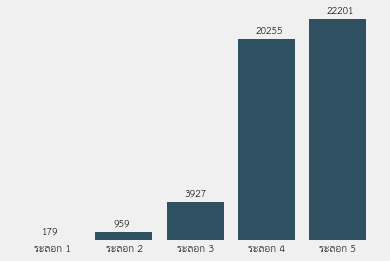

In [39]:
a_test=df.groupby(['announce_date','wave'])[['No']].count().reset_index()
dic_max={}
for i in a_test.wave.unique():
    infe_max=a_test.loc[a_test['wave']==i].No.max()
    dic_max[i]=infe_max

fig, ax = plt.subplots()
ind = np.arange(len(dic_max.values()))

ax.bar(dic_max.keys(),dic_max.values(),color='#2F5061')
for i, v in enumerate(dic_max.values()):
    ax.text(i-0.15 , v+500 , str(v), fontweight = 'bold')
plt.yticks([])
plt.grid(None)
plt.show()

In [40]:
print(mpl.matplotlib_fname())

/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/matplotlibrc


<h4>Question 2 <i>ทำไมจำนวนผู้ติดเชื้อในระลอกที่ 4 และ 5 ถึงมีจำนวนมาก (insight)</i></h4>

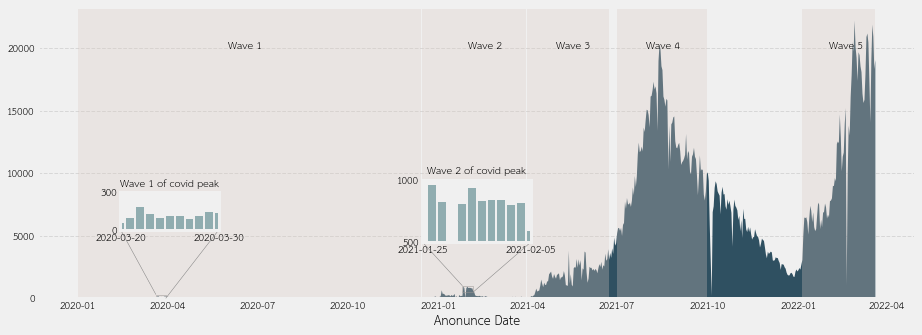

In [41]:
df3=df.groupby(['announce_date'])[['No']].count().reset_index()
peek_date={1:['2020-03-20','2020-03-30',0,300,0.15],   #
      2:['2021-01-25','2021-02-5',500,1000,0.5]}
plot_overall(df3,peek_date)

<p>เกิดจากสายพันธุ์แอลฟาที่ติดเร็วและเป็นช่วงเปิดSandbox</p>
<p style="font-size:12px">Reference<br>
    <a href="https://www.prachachat.net/general/news-838917">https://www.prachachat.net/general/news-838917</a><br>
    <a href= "https://www.thairath.co.th/scoop/infographic/2282636">https://www.thairath.co.th/scoop/infographic/2282636</a>
</p>

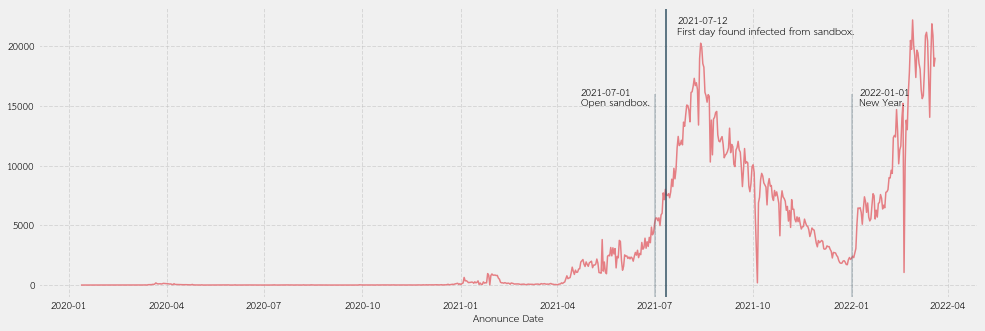

In [42]:
plt.figure(figsize=(15,5))
f_date=df.announce_date.loc[df.risk.str.contains('test|Test|sand|Sand',regex=True,na=False)].min()
temp=df.groupby(['announce_date'])[['No']].count().reset_index()
temp['log_10']=np.log10(temp.No)
temp['y_hat'] = scipy.signal.savgol_filter(temp['log_10'], 53, 10) # window size 51, polynomial order 3

plt.plot(temp.announce_date,temp.No,'#E57F84',linewidth =1.5)

plt.axvline(f_date,color='#2F5061',linewidth =1.5)
plt.axvline(datetime.strptime('2021-07-01','%Y-%m-%d'),color='#2F5061',linewidth =1.5,alpha=0.3,ymax=0.7)
plt.axvline(datetime.strptime('2022-01-01','%Y-%m-%d'),color='#2F5061',linewidth =1.5,alpha=0.3,ymax=0.7)
plt.text(f_date+dt.timedelta(10),21000,f_date.strftime("%Y-%m-%d")+'\nFirst day found infected from sandbox.',size=10)
plt.text(f_date-dt.timedelta(80),15000,'2021-07-01\nOpen sandbox.',size=10)
plt.text(f_date+dt.timedelta(180),15000,'2022-01-01\nNew Year.',size=10)
plt.xlabel('Anonunce Date',size=10)

plt.show()

<h4>Question 3 <i>จำนวนผู้ติดเชื้อในระลอกที่ 4 และ 5 คิดเป็นกี่เปอร์เซ็นตของระลอกที่ 1 - 3 (Stat)</i></h4>

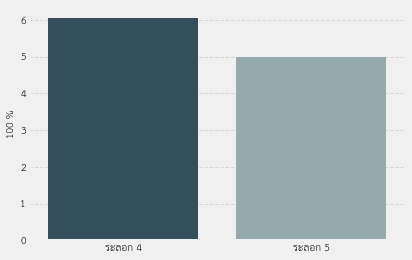

In [43]:
df['wave1_3']=np.nan

for i in list(wave_dict.keys())[:3]:
    idx=df.loc[df['wave']==i].index
    df.loc[idx,'wave1_3']='ระลอก1-3'
for i in list(wave_dict.keys())[3:]:
    idx=df.loc[df['wave']==i].index
    df.loc[idx,'wave1_3']=i
new_data=df.groupby(['wave1_3'])[['No']].count().reset_index().sort_values(by='No',ascending=False)

#plot
new_data['%']=new_data.No/new_data.No.min()
sns.barplot(data=new_data[0:2],x='wave1_3',y='%',palette=['#2F5061','#90adb0'])
plt.ylabel('100 %',size=10)
plt.yticks()
plt.xlabel(None)
plt.show()

<h4>Question 4 <i>ในช่วงการระบาดรอบที่ 1-3 และรอบที่ 4-5  อัตราส่วนผู้ติดเชื้อในแต่ละช่วงอายุเป็นท่าไหร่เมื่อเทียบกับจำนวนผู้ติดเชื้อในช่วงอายุที่มากที่สุด (Stat)</i></h4>

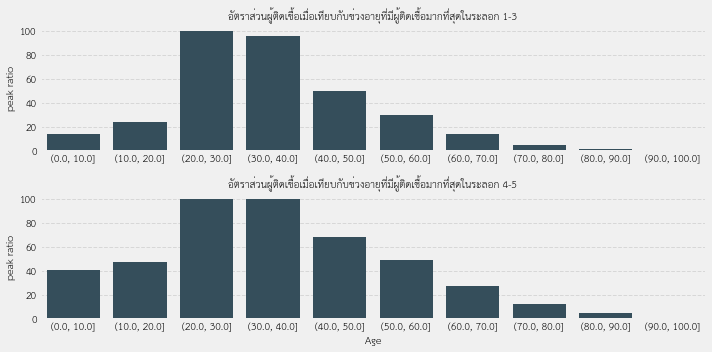

In [44]:
fig,axes=plt.subplots(2,1,figsize=(10,5))
num_infact_10 = df.loc[((df['sex']=='ชาย') | (df['sex']=='หญิง'))&(df.wave.str.contains('1|2|3',regex=True))]\
    .groupby(['age_10cut'])[['age_10cut']].agg('count').rename(columns={'age_10cut':'count'}).reset_index()
num_infact_10['p_ration'] = num_infact_10['count']/num_infact_10['count'].max()*100
num_infact_10=num_infact_10[:10] 
num_infact_10['age_10cut']=num_infact_10['age_10cut'].astype(str) 
bar1=sns.barplot(ax=axes[0], data=num_infact_10,x='age_10cut',y='p_ration',palette=['#2F5061'])
bar1.set_xlabel(None)
bar1.set_ylabel('peak ratio',size=10)
bar1.set_title('อัตราส่วนผู้ติดเชื้อเมื่อเทียบกับช่วงอายุที่มีผู้ติดเชื้อมากทึ่สุดในระลอก 1-3',size=10)
num_infact_10 = df.loc[((df['sex']=='ชาย') | (df['sex']=='หญิง'))&(df.wave.str.contains('4|5',regex=True))]\
    .groupby(['age_10cut'])[['age_10cut']].agg('count').rename(columns={'age_10cut':'count'}).reset_index()
num_infact_10['p_ration'] = num_infact_10['count']/num_infact_10['count'].max()*100
num_infact_10=num_infact_10[:10] 
num_infact_10['age_10cut']=num_infact_10['age_10cut'].astype(str) 
bar2=sns.barplot(ax=axes[1], data=num_infact_10,x='age_10cut',y='p_ration',palette=['#2F5061'])
bar2.set_ylabel('peak ratio',size=10)
bar2.set_xlabel('Age',size=10)
bar2.set_title('อัตราส่วนผู้ติดเชื้อเมื่อเทียบกับช่วงอายุที่มีผู้ติดเชื้อมากทึ่สุดในระลอก 4-5',size=10)

plt.tight_layout()
plt.show()

<h4>Question 4 <i>ในช่วงการระบาดรอบที่ 5  อัตราส่วนผู้ติดเชื้อในแต่ละช่วงอายุเป็นท่าไหร่เมื่อเทียบกับระลอกที่4 (insight)</i></h4>

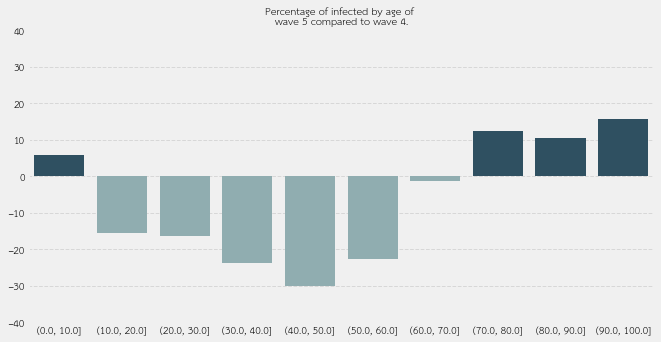

In [45]:
test_pi=df.loc[((df['sex']=='ชาย') | (df['sex']=='หญิง'))].groupby(['age_10cut','wave'])[['No']].count().reset_index()
test_pi=test_pi.pivot(index='age_10cut',columns='wave',values='No')
test_pi=test_pi.assign(diff_4_5=lambda x: (x['ระลอก 5']-x['ระลอก 4'])/x['ระลอก 4'] *100).reset_index()
test_pi=test_pi[:10] #อายุมากกว่า 100 มีจำนวนน้อยถ้าใส่เข้ามาอาจทำให้สื่อสารผิดพลาด
test_pi['age_10cut']=test_pi['age_10cut'].astype(str)  #not support category interval type plot

plt.figure(figsize=(10,5))
bar=sns.barplot(data=test_pi,
                x='age_10cut',y='diff_4_5')
for i in range(len(test_pi.age_10cut)):  
    if test_pi.diff_4_5[i]<0:
        bar.patches[i].set_facecolor('#90adb0')
    else:
        bar.patches[i].set_facecolor('#2F5061')   
bar.set(ylim=(-40, 40))

plt.title('Percentage of infected by age of \nwave 5 compared to wave 4.',size=10)
plt.xlabel(None)
plt.ylabel(None)
plt.show()

<h4>Question 5 <i>เปอร์เซนต์ของผู้ติดเชื้อในแต่ละภาคเป็นเท่าไหร่ (stat)</i></h4>

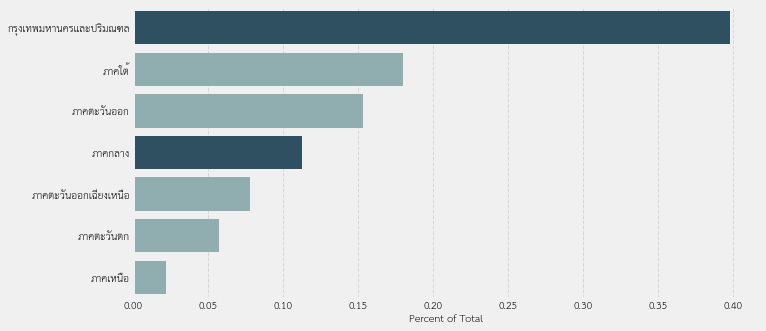

In [46]:
#Q4 ภาพรวมเปอร์เซ็นต์ผู้ติดเชื้อแต่ละจังหวัด
plt.figure(figsize=(10,5))
mop_g=df.groupby('MOPH')[['No']].count().reset_index().sort_values(by='No',ascending=False)
mop_g['1M']=mop_g.No/1000000
mop_g['%']=mop_g.No/mop_g.No.sum()
# mop_g['peak_r']=mop_g['%'].cumsum()
bar=sns.barplot(data=mop_g,y='MOPH',x='%')

for i in range(7):   #กำหนด face color
    if i==0 or i==3:
        bar.patches[i].set_facecolor('#2F5061')
    else:
        bar.patches[i].set_facecolor('#90adb0')   
         
plt.xlabel('Percent of Total',size=10)
plt.ylabel(None)
plt.show()

<h4>Question 6 <i>ทำไมภาคใต้/ตะวันออกถึง มียอดผู้ติดเชื้อสูงกว่าภาคกลาง (insight)</i></h4>
<p>จากกราฟทำให้เห็นว่าภาคใต้มีผู้ติดเชื้อเพิ่มขึ้นในช่วงเดือน 10 แต่ภาคตะวันออกลดลงซึ่งเป็นแนวโน้มเดียวกับภาคอื่น แสดงให้เห็นว่าภาคใต้มีบางอย่างที่น่าจะผิดปกติ<br>
โดยอาจเป็นผลจากการที่ภาคใต้มีประเพณีสารทเดือน 10 </p>

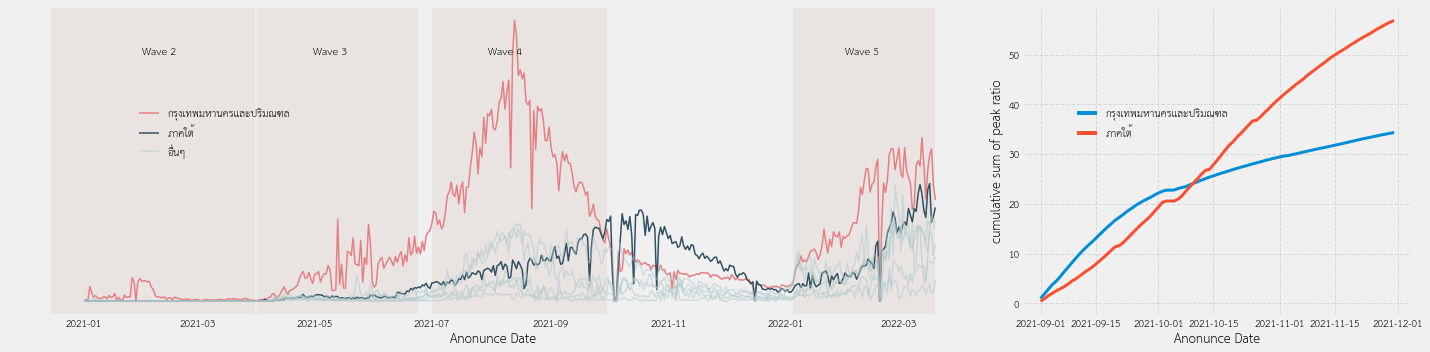

In [47]:
palette=    [['กรุงเทพมหานครและปริมณฑล','#E57F84'],
            ['ภาคใต้','#2F5061'],
            ['ภาคตะวันตก','#adc7c9'],
            ['ภาคเหนือ','#adc7c9'],
            ['ภาคตะวันออก','#adc7c9'],
            ['ภาคกลาง','#adc7c9'],
            ['ภาคตะวันออกเฉียงเหนือ','#adc7c9']]

f, (a0, a1) = plt.subplots(1, 2,figsize=(20,5), gridspec_kw={'width_ratios': [5, 2]})
for i in palette:
    temp_data=df2.loc[(df2.MOPH==i[0])&(df2.announce_date>='2021-01-01')].groupby(['announce_date'])[['No']].sum().reset_index()
    if( i[0]!='กรุงเทพมหานครและปริมณฑล' and i[0] !='ภาคใต้'):
        a0.plot(temp_data.announce_date, temp_data.No,i[1],linewidth =1.5,alpha=0.5)
    else:
        a0.plot(temp_data.announce_date, temp_data.No,i[1],linewidth =1.5)
a0.legend(['กรุงเทพมหานครและปริมณฑล', 'ภาคใต้','อื่นๆ'],loc='upper right', bbox_to_anchor=(0.3, 0.7),frameon=False)
a0.axvspan(pd.Timestamp('2020-12-15'),pd.Timestamp('2021-03-31'),facecolor='#dbcac3',alpha=0.3)    #ระลอก 2 
a0.axvspan(pd.Timestamp('2021-04-01'),pd.Timestamp('2021-06-23'),color='#dbcac3',alpha=0.3)        #ระลอก 3 
a0.axvspan(pd.Timestamp('2021-07-01'),pd.Timestamp('2021-09-30'),facecolor='#dbcac3',alpha=0.3)    #ระลอก 4
a0.axvspan(pd.Timestamp('2022-01-05'),pd.Timestamp(df.announce_date.max()),facecolor='#dbcac3',alpha=0.3)   #ระลอก 5
for i,j in zip(['2021-01-31','2021-04-30','2021-07-30','2022-02-01'],
                ['Wave 2','Wave 3','Wave 4','Wave 5']):
    a0.text(x=pd.Timestamp(i),y=10000,s=j)

a0.grid(None)
a0.set_xlabel('Anonunce Date')
a0.set_yticklabels([])

b_s=pd.DataFrame(columns=['announce_date','MOPH','No','ratio','cumsum','r_cumsum'])
for i in ['กรุงเทพมหานครและปริมณฑล','ภาคใต้']:
    temp = df.loc[(df.MOPH==i)&\
    ((df.announce_date>='2021-09-01')&(df.announce_date<='2021-11-30'))].groupby(['announce_date','MOPH'])[['No']].count().reset_index()
    temp['ratio']=temp.No/temp.No.max()
    temp['cumsum']=temp.No.cumsum()
    temp['r_cumsum']=temp.ratio.cumsum()
    b_s=pd.concat([b_s, temp],axis=0,ignore_index=True)

sns.lineplot(data=b_s,x='announce_date',y='r_cumsum',hue='MOPH',linewidth=3)
a1.legend(loc='upper right', bbox_to_anchor=(0.55, 0.7),frameon=False)
a1.set_ylabel('cumulative sum of peak ratio')
a1.set_xlabel('Anonunce Date')
f.tight_layout()
plt.show()


<h4>Question 7 <i>อัตราส่วนผู้ติดเชื้อในภาพรวมทั้งประเทศเป็นอย่างไรตลอดการระบาดทั้ง 5 รอบที่ผ่านมา (insight)</i></h4>


<h4>Question 8 <i>ทำไมช่วง 2020-04 และ 2021-04 ถึงมีแนวโน้มที่แตกต่างกัน(insight)</i></h4>
<p>ก่อนหน้า2021-04 ไม่ได้มีมาตรการบังคับใช้ที่เข้มงวดจึงทำให้ผู้คนเดินทางข้ามจังหวัดกันปกติ ซึ่งแตกต่างกับ 2020-04 ที่รัฐประกาศปิดกิจกรรมต่างๆ ที่กรุงเทพมหานคร <br>
ก่อนเดือน 4 จึงทำให้ผู้คนเดิอนทางออกต่างจังหวัดจึงเกิดการแพร่กระจายมากขึ้น จึงทำให้หลายจังหวัดเริ่ม lock down ส่งผลให้ผู้ติดเชื้อลดลง
</p>
<p style="font-size:12px">Reference<br>
    <a href="https://tdri.or.th/2021/03/covid19-measures-long-holiday/">https://tdri.or.th/2021/03/covid19-measures-long-holiday/</a></p>


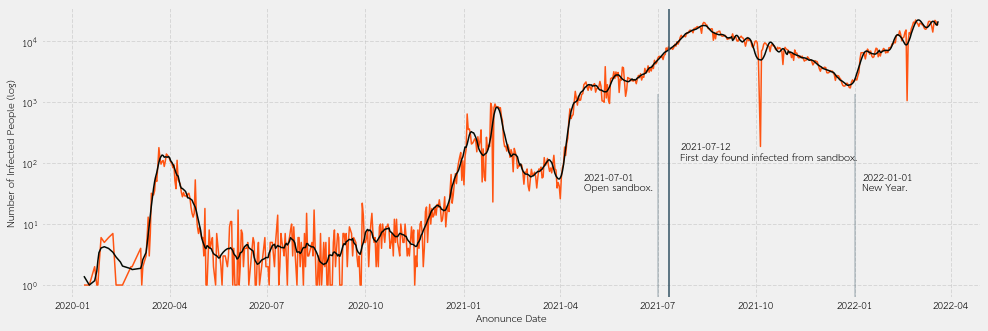

In [48]:

temp2=df.groupby(['announce_date'])[['No']].count().reset_index()
temp2['log_10']=np.log10(temp2.No)
temp2['y_hat'] = scipy.signal.savgol_filter(temp2['log_10'], 53, 10) # window size 51, polynomial order 10

fig,ax = plt.subplots(figsize=(15,5))
ax.plot(temp2.announce_date,temp2.No,'#FF5412',linewidth =1.5)
ax.set_yscale('log')
ax.set_ylabel('Number of Infected People (log)',size=10)

ax2=ax.twinx()
ax2.plot(temp2.announce_date,temp2.y_hat,'#030A04',linewidth =1.5)
ax2.set_yticklabels([])
ax2.grid(None)

plt.axvline(f_date,color='#2F5061',linewidth =1.5)
plt.axvline(datetime.strptime('2021-07-01','%Y-%m-%d'),color='#2F5061',linewidth =1.5,alpha=0.3,ymax=0.7)
plt.axvline(datetime.strptime('2022-01-01','%Y-%m-%d'),color='#2F5061',linewidth =1.5,alpha=0.3,ymax=0.7)
plt.text(f_date+dt.timedelta(10),2,f_date.strftime("%Y-%m-%d")+'\nFirst day found infected from sandbox.',size=10)
plt.text(f_date-dt.timedelta(80),1.5,'2021-07-01\nOpen sandbox.',size=10)
plt.text(f_date+dt.timedelta(180),1.5,'2022-01-01\nNew Year.',size=10)

ax.set_xlabel('Anonunce Date',size=10)
plt.show()

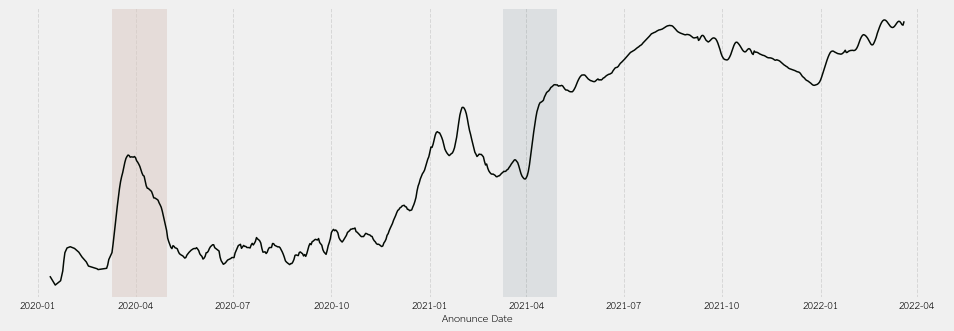

In [49]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(temp2.announce_date,temp2.y_hat,'#030A04',linewidth =1.5)
ax.axvspan(pd.Timestamp('2020-03-10'),pd.Timestamp('2020-04-30'),facecolor='#dbcac3',alpha=0.5)
ax.axvspan(pd.Timestamp('2021-03-10'),pd.Timestamp('2021-04-30'),facecolor='#2F5061',alpha=0.1)
plt.yticks([])
plt.xlabel('Anonunce Date',size=10)
plt.show()

<h4>Question 9 <i> รูปแบบการเพิ่มจำนวนของผู้ติดเชื้อใน 4 กลุ่มเสี่ยงเป็นอย่างไร (insight)</i></h4>


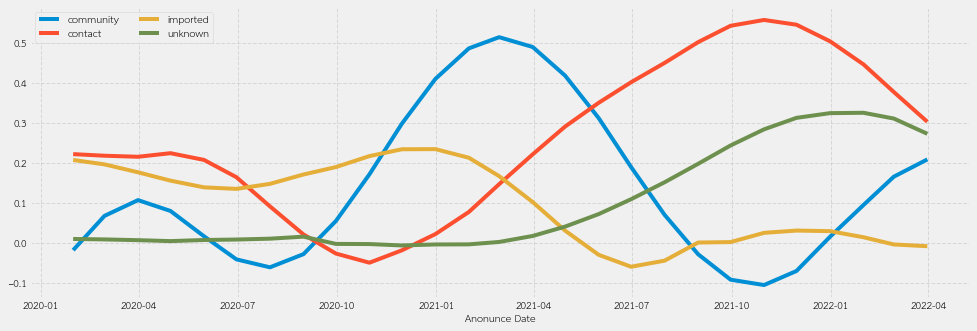

In [50]:
m_y=df.groupby(['announce_date','risk_group'])[['No']].count().reset_index()
m_y=m_y.pivot(index='announce_date',columns='risk_group',values='No')
m_y=m_y.resample("d").sum().fillna(0)
m_y=m_y.groupby(pd.Grouper(freq="M")).sum()
m_y=m_y.div(m_y.sum(axis=1), axis=0)
m_y=m_y.unstack().reset_index().rename(columns={0:'No'})
m_y['smoot']=scipy.signal.savgol_filter(m_y['No'], 41, 10)
plt.figure(figsize=(15,5))
sns.lineplot(data=m_y.loc[m_y.risk_group.str.contains('imported|unknow|community|contact')],x='announce_date',y='smoot',hue='risk_group')
plt.legend(ncol=2, loc="upper left", frameon=True)
plt.xlabel('Anonunce Date',size=10)
plt.ylabel(None)
plt.show()

<h4>Question 10 <i> แนวโน้มโควิดในประเทศไทยจะเป็นอย่างไรต่อไปเมื่อเทียบกับในอดีตที่ผ่านมา (insight)</i></h4>

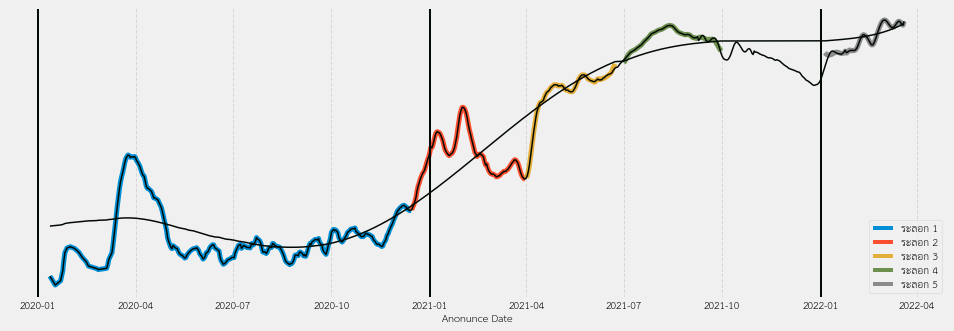

In [51]:
temp3=df.groupby(['announce_date','wave'])[['No']].count().reset_index()
temp3['log_10']=np.log10(temp3.No)
temp3['y_hat'] = scipy.signal.savgol_filter(temp3['log_10'], 53, 10) # window size 51, polynomial order 3

X=np.array(temp3.index)
X=X.reshape(-1,1)
y=np.array(temp3.y_hat)
y=y.reshape(-1,1)
degree=5
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(X,y)
temp3['pre']=polyreg.predict(X)


plt.figure(figsize=(15,5))
ax=sns.lineplot(data=temp3,y='y_hat',x='announce_date',hue='wave',linewidth =5)
ax.legend(title=None);

plt.plot(temp2.announce_date,temp2.y_hat,'#030A04',linewidth =1.5)
plt.plot(temp3.announce_date,temp3.pre,'#030A04',linewidth =1.5)

plt.axvline(datetime.strptime('2020-01-01','%Y-%m-%d'),color='#030A04',linewidth =2)
plt.axvline(datetime.strptime('2021-01-01','%Y-%m-%d'),color='#030A04',linewidth =2)
plt.axvline(datetime.strptime('2022-01-01','%Y-%m-%d'),color='#030A04',linewidth =2)

plt.yticks([])
plt.ylabel(None)
plt.xlabel('Anonunce Date',size=10)
plt.show()